In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout

/tmp/ipykernel_100080/3131160384.py:1: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd
2024-06-03 19:18:19.348631: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-06-03 19:18:23.868801: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
df = pd.read_csv('data.csv')
df

,symbol,date,open,high,low,close,volume
0,AAL,2014-01-02,25.0700,25.8200,25.0600,25.3600,8998943
1,AAPL,2014-01-02,79.3828,79.5756,78.8601,79.0185,58791957
2,AAP,2014-01-02,110.3600,111.8800,109.2900,109.7400,542711
3,ABBV,2014-01-02,52.1200,52.3300,51.5200,51.9800,4569061
4,ABC,2014-01-02,70.1100,70.2300,69.4800,69.8900,1148391
...,...,...,...,...,...,...,...
497467,XYL,2017-12-29,68.5300,68.8000,67.9200,68.2000,1046677
497468,YUM,2017-12-29,82.6400,82.7100,81.5900,81.6100,1347613
497469,ZBH,2017-12-29,121.7500,121.9500,120.6200,120.6700,1023624
497470,ZION,2017-12-29,51.2800,51.5500,50.8100,50.8300,1261916


In [3]:
df['date'] = pd.to_datetime(df['date'])
df['open'] = pd.to_numeric(df['open'], errors='coerce')
df['high'] = pd.to_numeric(df['high'], errors='coerce')
df['low'] = pd.to_numeric(df['low'], errors='coerce')
df['close'] = pd.to_numeric(df['close'], errors='coerce')
df['volume'] = pd.to_numeric(df['volume'], errors='coerce')
df.dtypes

symbol            object
date      datetime64[ns]
open             float64
high             float64
low              float64
close            float64
volume             int64
dtype: object

In [4]:
df.dropna(inplace=True)

In [5]:
symbol_counts = df['symbol'].value_counts()
good_symbols = list(symbol_counts[symbol_counts >= 1007].index)
df_good = df[df['symbol'].isin(good_symbols)]

In [6]:
df_good = df_good.set_index(['symbol', 'date'])
df_good

,,open,high,low,close,volume
symbol,date,,,,,
AAL,2014-01-02,25.0700,25.8200,25.0600,25.3600,8998943
AAPL,2014-01-02,79.3828,79.5756,78.8601,79.0185,58791957
AAP,2014-01-02,110.3600,111.8800,109.2900,109.7400,542711
ABBV,2014-01-02,52.1200,52.3300,51.5200,51.9800,4569061
ABC,2014-01-02,70.1100,70.2300,69.4800,69.8900,1148391
...,...,...,...,...,...,...
XYL,2017-12-29,68.5300,68.8000,67.9200,68.2000,1046677
YUM,2017-12-29,82.6400,82.7100,81.5900,81.6100,1347613
ZBH,2017-12-29,121.7500,121.9500,120.6200,120.6700,1023624


In [7]:
data = df_good[['close', 'volume']]
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data)
scaled_data

array([[0.01160979, 0.01449066],
       [0.03781778, 0.09503624],
       [0.05282283, 0.00081179],
       ...,
       [0.05816129, 0.00158972],
       [0.0240499 , 0.00197519],
       [0.03440933, 0.0026905 ]])

In [8]:
window = 60
X = []
y = []

for i in range(window, len(data)):
    X.append(scaled_data[i-window:i])
    y.append(scaled_data[i, 0])
    
X, y = np.array(X), np.array(y)
X.shape, y.shape

((480279, 60, 2), (480279,))

In [9]:
train_size = int(X.shape[0]*0.8)
x_train = X[:train_size]
y_train = y[:train_size]
x_test = X[train_size:]
y_test = y[train_size:]

In [10]:
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(x_train.shape[1], x_train.shape[2])))
model.add(Dropout(0.2))
model.add(LSTM(units=50, return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(units=25))
model.add(Dense(units=1))

model.compile(optimizer='adam', loss='mean_squared_error')

model.fit(x_train, y_train, batch_size=32, epochs=20)

2024-06-03 19:18:30.538699: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:282] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
/home/vinicius/.local/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/20
12007/12007 ━━━━━━━━━━━━━━━━━━━━ 391s 32ms/step - loss: 0.0019
Epoch 2/20
12007/12007 ━━━━━━━━━━━━━━━━━━━━ 420s 35ms/step - loss: 0.0015
Epoch 3/20
12007/12007 ━━━━━━━━━━━━━━━━━━━━ 394s 33ms/step - loss: 0.0011
Epoch 4/20
12007/12007 ━━━━━━━━━━━━━━━━━━━━ 395s 33ms/step - loss: 0.0019
Epoch 5/20
12007/12007 ━━━━━━━━━━━━━━━━━━━━ 397s 33ms/step - loss: 8.8315e-04
Epoch 6/20
12007/12007 ━━━━━━━━━━━━━━━━━━━━ 398s 33ms/step - loss: 6.2476e-04
Epoch 7/20
12007/12007 ━━━━━━━━━━━━━━━━━━━━ 400s 33ms/step - loss: 5.3191e-04
Epoch 8/20
12007/12007 ━━━━━━━━━━━━━━━━━━━━ 400s 33ms/step - loss: 3.6676e-04
Epoch 9/20
12007/12007 ━━━━━━━━━━━━━━━━━━━━ 402s 33ms/step - loss: 2.8079e-04
Epoch 10/20
12007/12007 ━━━━━━━━━━━━━━━━━━━━ 404s 34ms/step - loss: 2.7079e-04
Epoch 11/20
12007/12007 ━━━━━━━━━━━━━━━━━━━━ 403s 34ms/step - loss: 1.6241e-04
Epoch 12/20
12007/12007 ━━━━━━━━━━━━━━━━━━━━ 408s 34ms/step - loss: 1.5944e-04
Epoch 13/20
12007/12007 ━━━━━━━━━━━━━━━━━━━━ 409s 34ms/step - loss: 1.9842e-0

In [11]:
from sklearn.metrics import mean_squared_error
predictions = model.predict(x_test)
close_scaler = MinMaxScaler(feature_range=(0, 1))
close_scaler.fit(data[['close']])
predictions = close_scaler.inverse_transform(predictions)
y_test_actual = close_scaler.inverse_transform(y_test.reshape(-1, 1))

rmse = np.sqrt(mean_squared_error(y_test_actual, predictions))
rmse

3002/3002 ━━━━━━━━━━━━━━━━━━━━ 32s 10ms/step


40.137566018229805

/tmp/ipykernel_100080/1124684575.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['Predictions'] = predictions
/tmp/ipykernel_100080/1124684575.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['Spread'] = valid['close'] - valid['Predictions']


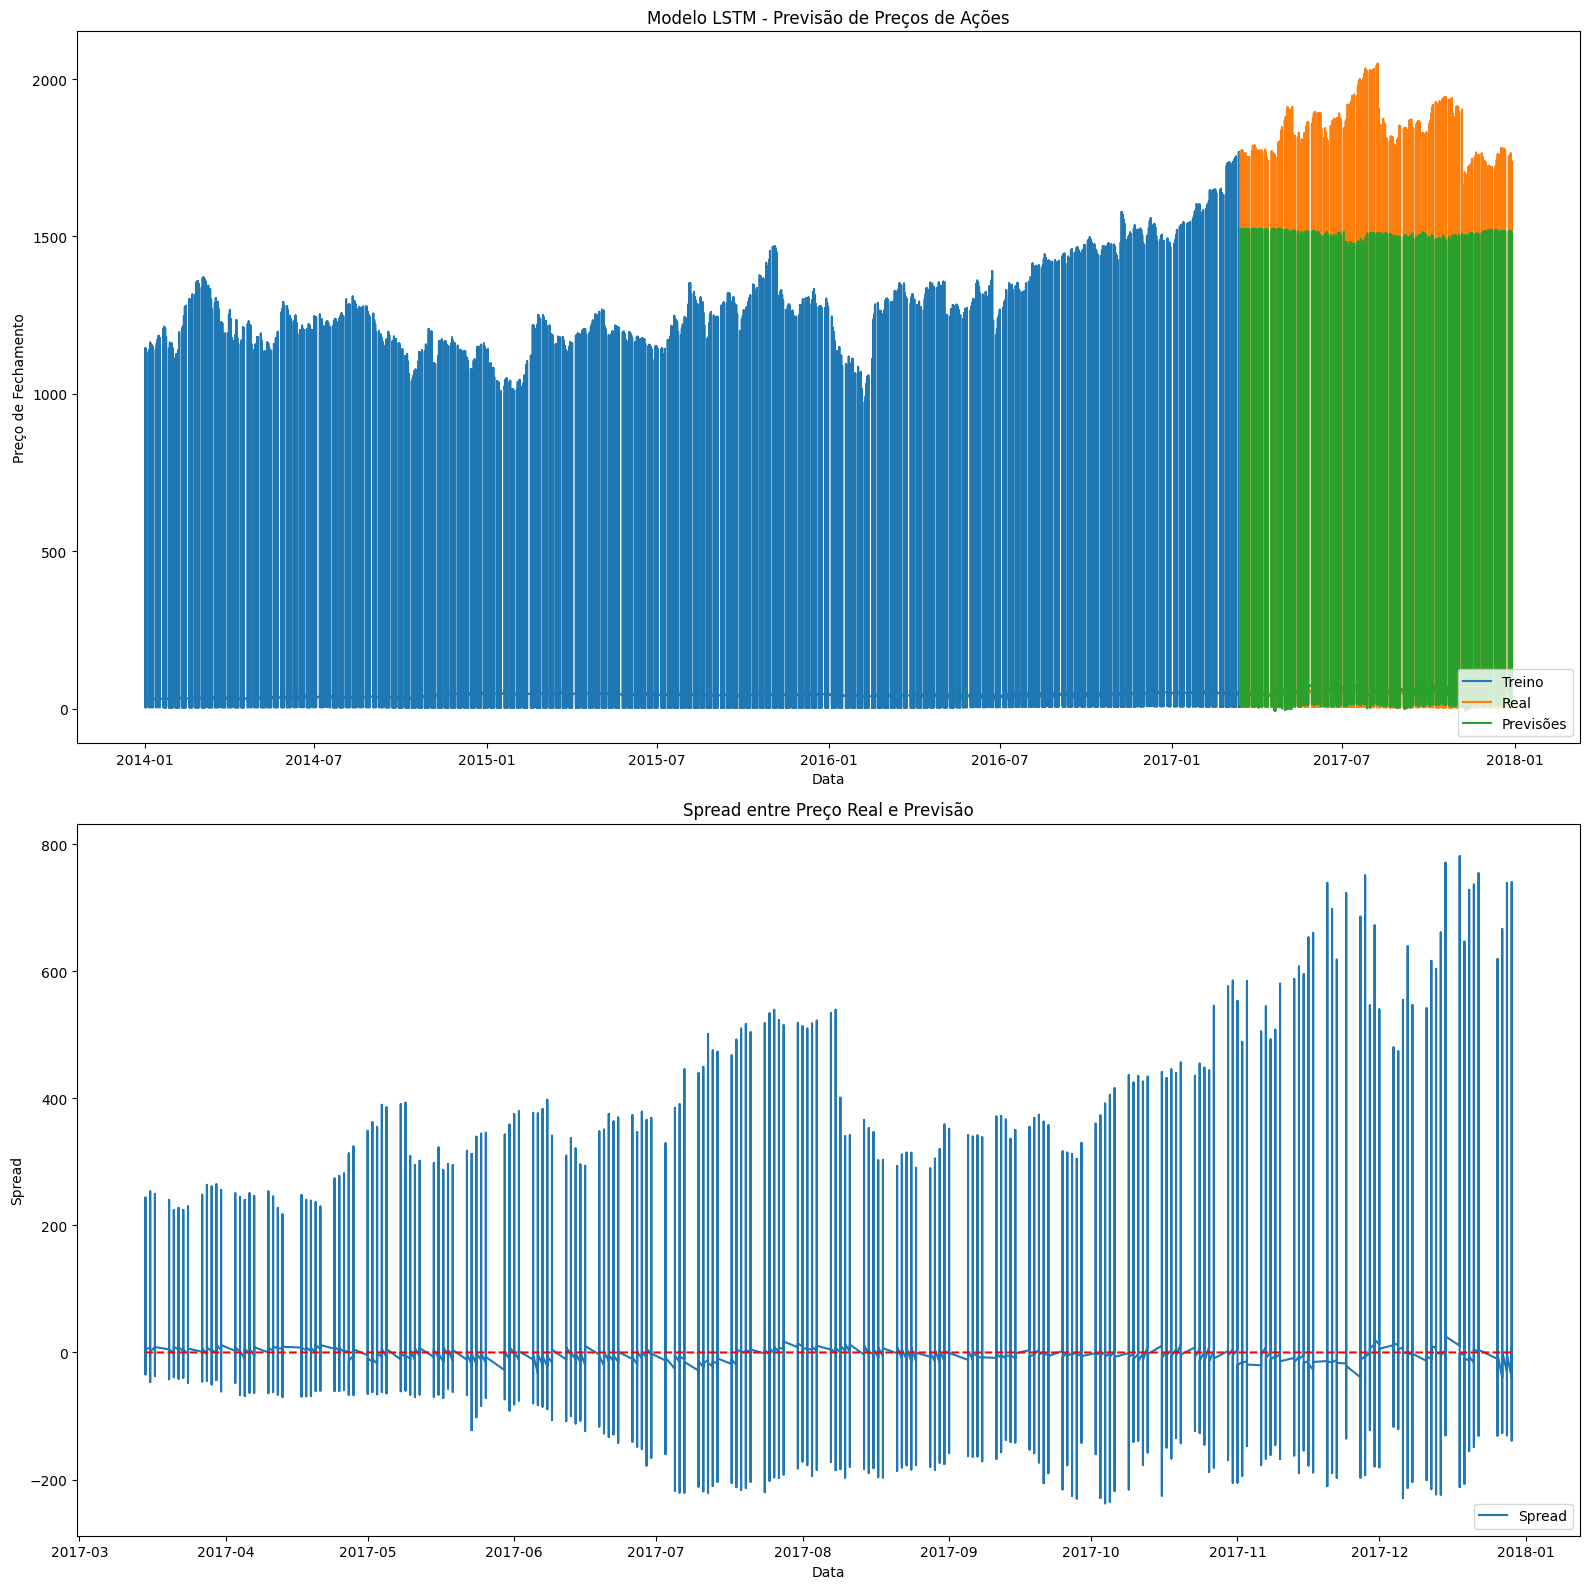

In [13]:
train = data[:train_size]
valid = data[train_size + window:]
valid['Predictions'] = predictions
valid['Spread'] = valid['close'] - valid['Predictions']

plt.figure(figsize=(16, 16))

plt.subplot(2, 1, 1)
plt.title('Modelo LSTM - Previsão de Preços de Ações')
plt.xlabel('Data')
plt.ylabel('Preço de Fechamento')
plt.plot(train.index.get_level_values(1), train['close'])
plt.plot(valid.index.get_level_values(1), valid[['close', 'Predictions']])
plt.legend(['Treino', 'Real', 'Previsões'], loc='lower right')

plt.subplot(2, 1, 2)
plt.title('Spread entre Preço Real e Previsão')
plt.xlabel('Data')
plt.ylabel('Spread')
plt.plot(valid.index.get_level_values(1), valid['Spread'])
plt.plot(valid.index.get_level_values(1), [0] * len(valid.index.get_level_values(1)), 'r--')
plt.legend(['Spread'], loc='lower right')

plt.tight_layout()
plt.show()